In [0]:
import torch
import torchvision 
from torchvision import datasets, transforms, models
from torch import nn, optim

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])  
trainset = datasets.CIFAR10('./data/', download=True, train=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10('./data/', download=True, train=False, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
print(f"training set contains : {len(trainset)} images")
print(f"testing set contains : {len(testset)} images")


training set contains : 50000 images
testing set contains : 10000 images


In [0]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py


--2019-06-24 14:17:46--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



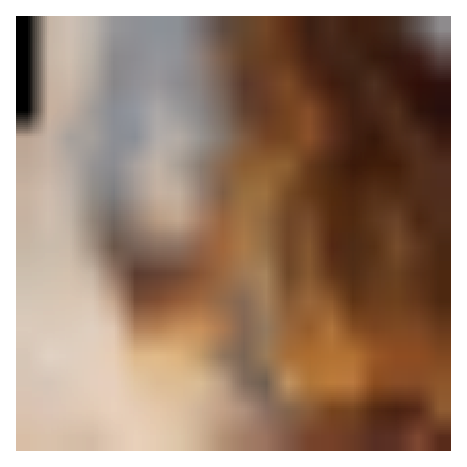

In [0]:
import helper
images, labels = next(iter(trainloader))
helper.imshow(images[0,:]);

In [0]:
print(images.shape)

torch.Size([64, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([6, 3, 0, 6, 3, 3, 0, 9, 4, 1, 6, 5, 4, 4, 6, 7, 4, 2, 7, 4, 1, 7, 6, 5,
        1, 8, 2, 7, 6, 9, 5, 1, 2, 1, 0, 0, 9, 3, 2, 7, 4, 7, 8, 0, 7, 9, 5, 3,
        4, 8, 9, 7, 0, 2, 5, 2, 4, 4, 8, 1, 9, 4, 7, 4])


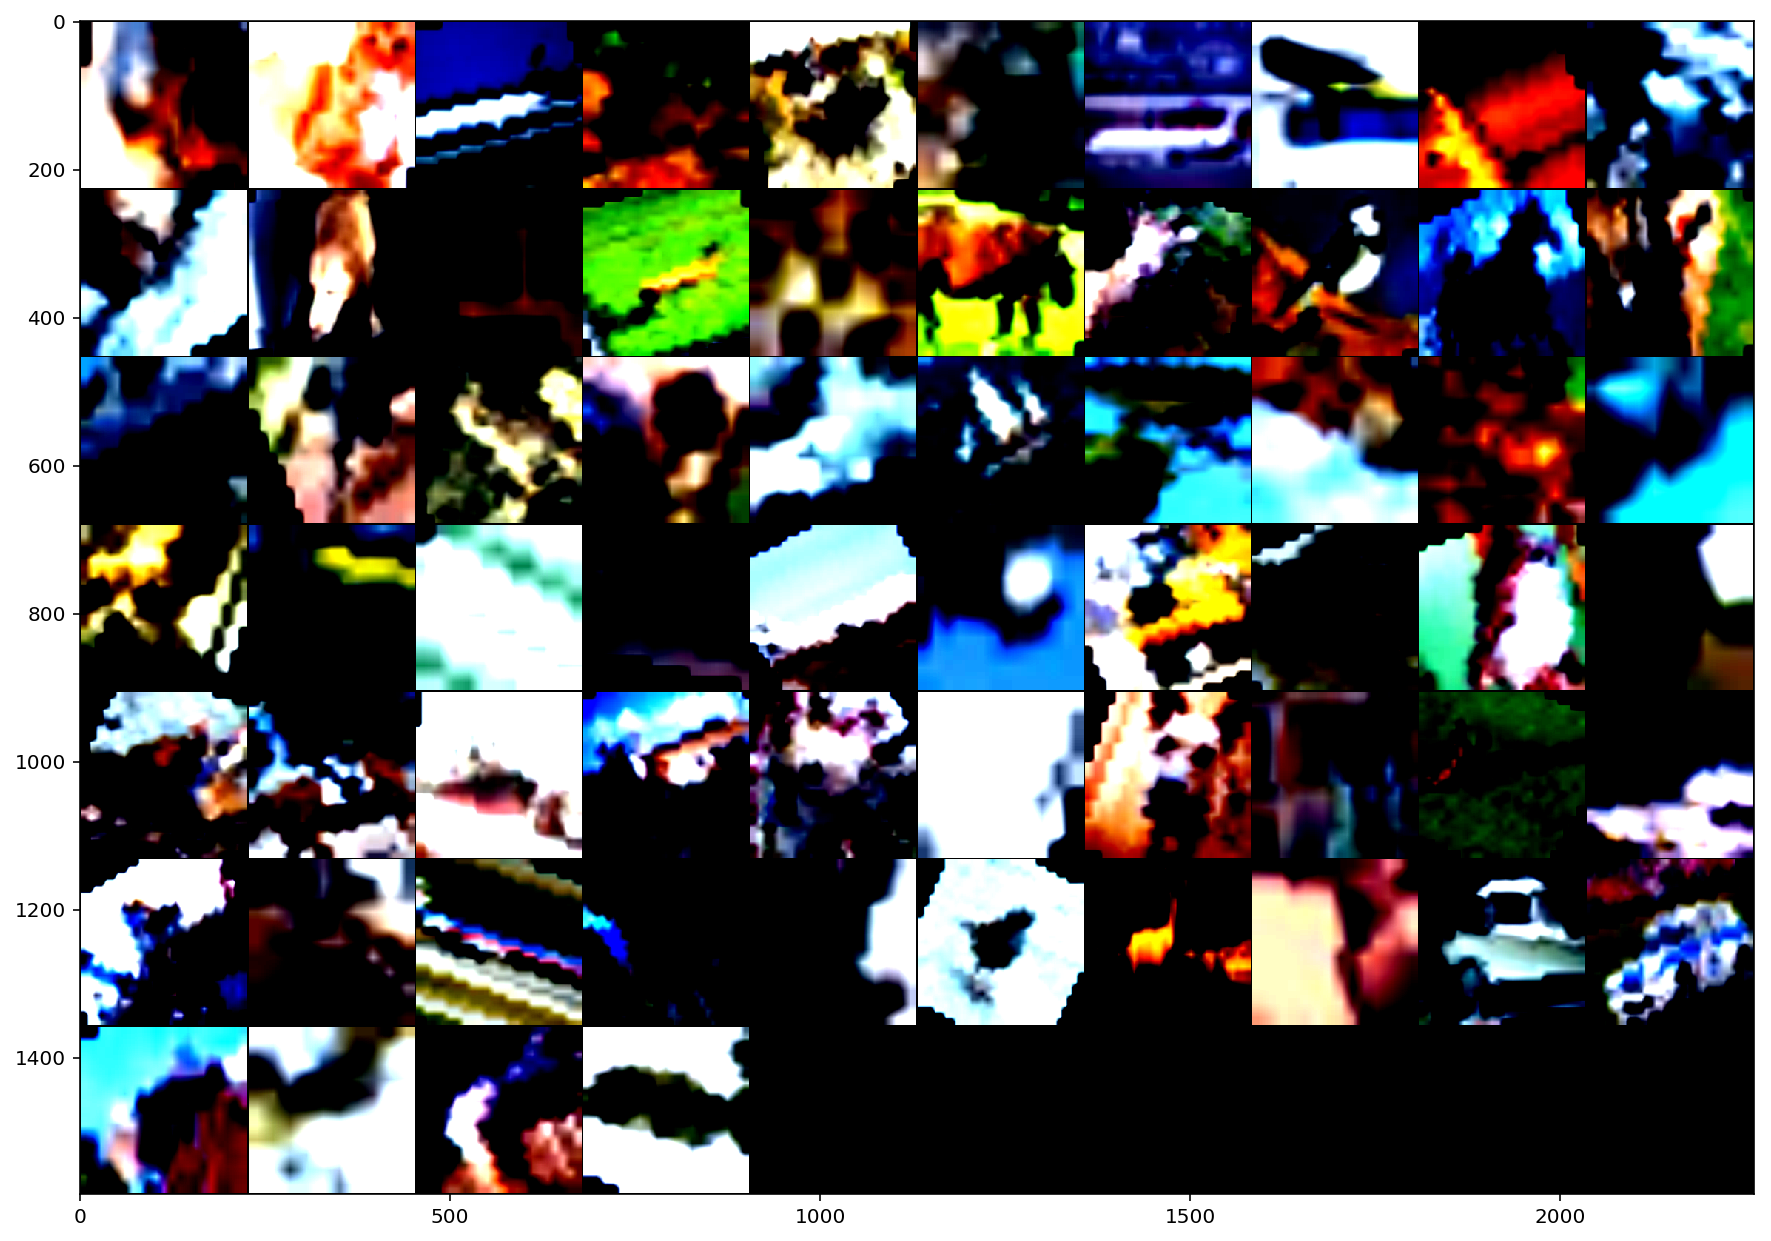

In [0]:
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 10, padding = 2)
plt.figure(figsize = (15, 15))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)

In [0]:
#
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
#from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048, 512),nn.ReLU(),nn.Dropout(p=0.5),nn.Linear(512,10),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()


optimizer = torch.optim.Adam(model.fc.parameters() , lr = 0.01)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


model.to(device);

In [0]:
epochs = 20
train_losses, test_losses = [], []
model.train()
for e in range(epochs):
  running_loss = 0
  #scheduler.step()
  for images, labels in trainloader:
    optimizer.zero_grad()
    images = images.to(device)  
    labels = labels.to(device)
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        images = images.to(device)  
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps,labels)
        ps = torch.exp(log_ps)
        top_p , top_class = ps.topk(1,dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))   
    print("Epoch: {}/{}.. ".format(e+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),"Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    

Epoch: 1/20..  Training Loss: 1.633..  Test Loss: 0.996..  Test Accuracy: 0.651


KeyboardInterrupt: ignored

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)